In [1]:
# load dataset
import dataloader
import utilities
import transcribe
import madmom
import os
import features
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

parameters = {
        "chroma_type":"crp",  # crp or dcp
        "vocabulary":"majmin",  # majmin, triads, triads_extended or majmin_sevenths
        "eval_scheme":"majmin",
        "source_separation":"None", # hprs, demucs or None
        "prefilter":"median", # None, "median"#
        "embedding":7,
        "neighbours":50,
        "prefilter_length":7,  # N 
        "postfilter":"hmm", # None, "hmm" or "median"
        "transition_prob":0.3,  # 0..1
        "postfilter_length":1, # N
}

PATH = "/home/max/ET-TI/Masterarbeit/mirdata/"
output_path = "/home/max/ET-TI/Masterarbeit/results/"
results= []
print(f"Starting Transcription!")
for dataset_name in ["beatles","rwc_popular"]:
    print(f"Dataset: {dataset_name}")
    for fold in range(1,9):
        dataset = dataloader.MIRDataset(dataset_name,basepath=PATH,split_nr=fold)
        for track_id in tqdm(dataset.getTrackList(),desc=f"fold {fold}/8"):
            name = dataset.getTitle(track_id).split("_-_")[-1]
            audiopath,(ref_intervals,ref_labels) = dataset[track_id]

            if parameters.get("chroma_type","crp") == "dcp":
                # Transcribe with madmoms deep chroma processor and a conditional random field
                time_vector,signal = utilities.loadAudio(audiopath)
                t_chroma,chroma = features.deepChroma(signal,split_nr=fold)
                est_intervals,est_labels = transcribe.transcribeDeepChroma(t_chroma,chroma)
                score,seg_score = transcribe.evaluateTranscription(est_intervals,est_labels,ref_intervals,ref_labels,parameters.get("eval_scheme","majmin"))
                results.append((dataset_name,name,score,seg_score))
                continue

            ## HPS ##
            if parameters.get("source_separation",False) == "hprs":
                time_vector,signal = utilities.loadAudio(audiopath)
                y_harm,y_perc,y_res = transcribe.harmonicPercussiveResidualSeparation(signal,beta=3,n_fft=4096)
                signal = madmom.audio.signal.Signal(y_harm, sample_rate=signal.sample_rate, num_channels=1, start=signal.start, stop=signal.stop)
                rms = features.rms(signal,hop_length=4096)
            elif parameters.get("source_separation",False) == "demucs":
                basepath,filename = os.path.split(audiopath)
                filename = filename.rsplit('.', 1)[0]
                audiopath = basepath+"/instrumentals/"+filename+"_instrumental.mp3"
                time_vector,signal = utilities.loadAudio(audiopath)
                rms = features.rms(signal,hop_length=4096)
            else:
                time_vector,signal = utilities.loadAudio(audiopath)
                rms = features.rms(signal,hop_length=4096)

            if parameters.get("chroma_type","crp") == "crp":    
                t_chroma,chroma = features.crpChroma(signal)

            est_intervals, est_labels = transcribe.transcribeChromagram(t_chroma,chroma,rms,**parameters)
            score,seg_score = transcribe.evaluateTranscription(est_intervals,est_labels,ref_intervals,ref_labels,parameters.get("eval_scheme","majmin"))
            results.append((dataset_name,name,score,seg_score))
print(f"majmin songs with > 30%:")
majmin = [x[2] for x in results if x[2] > 0.3]
print(np.sum(majmin)/len(majmin))

ModuleNotFoundError: No module named 'typing_extensions'

Visualize the Results

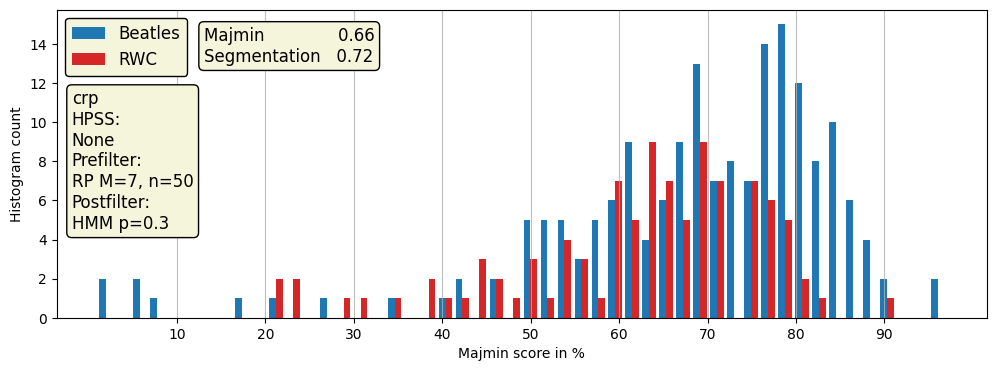

In [19]:
# create Strings for textboxes

# retrieve parameters
image_path="/home/max/ET-TI/Masterarbeit/latex/figures/"
source_separation = parameters.get("source_separation","None")
prefilter = parameters.get("prefilter","None")
chroma_type = parameters.get("chroma_type","crp")
SAVE = False

if chroma_type == "dcp":
        parameterstring = f"DCP+CRF\nHPSS:\n{source_separation}"
else:
        if prefilter == "median":
                parameterstring = f"{chroma_type}\nHPSS:\n{source_separation}\nPrefilter:\nMedian N={parameters.get('prefilter_length',15)}\n\Postfilter:\nHMM p={parameters.get('transition_prob',0.3)}"
        elif prefilter == "rp":
                parameterstring = f"{chroma_type}\nHPSS:\n{source_separation}\nPrefilter:\nRP M={parameters.get('embedding',1)}, n={parameters.get('neighbours',10)}\nPostfilter:\nHMM p={parameters.get('transition_prob',0.3)}"
scorestring =  f"Majmin              {np.mean(np.array([x[2] for x in results])):0.02f}\n"
scorestring += f"Segmentation   {np.mean(np.array([x[3] for x in results])):0.02f}"

beatles_majmin_scores = [100*x[2] for x in results if x[0] == "beatles"]
rwc_majmin_scores = [100*x[2] for x in results if x[0] == "rwc_popular"]
fig,ax = plt.subplots(figsize=(12,4))
ax.hist([beatles_majmin_scores,rwc_majmin_scores],50,color=["tab:blue","tab:red"]);
ax.legend(["Beatles","RWC"],framealpha=1,edgecolor="black",fontsize=12,facecolor="beige",loc="upper left")
# place a text box in upper left in axes coords
ax.text(0.016, 0.74, parameterstring, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round',facecolor='beige', alpha=1))
ax.text(0.158, 0.945,scorestring , transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round',facecolor='beige', alpha=1))
ax.set_xlabel("Majmin score in %")
ax.set_ylabel("Histogram count");
ax.set_xticks(np.arange(10,100,10))
ax.grid(axis='x',linestyle="-",alpha=0.8)
if SAVE:
        fig.savefig(image_path,dpi=660,pad_inches=0)

CRP, N=10, p=0.2 : majmin: 0.69, segmentation: 0.75
CRP, N=12, p=0.15 : majmin: 0.69, segmentation: 0.75
CRP, N=15, p=0.15 : majmin: 0.69, segmentation: 0.74 
DEMUCS, CRP : majmin: 0.72, segmentation: 0.76
DEMUCS, CRP RP(5,15) majmin: 0.69, segmentation 0.74
HPRS, CRP: majmin: 0.7 , segmentation: 0.75


Reference Model: Deep chroma processor
majmin: 0.84, segmentation: 0.89

In [60]:
import numpy as np
results = []
for fold in range(1,9):
    dataset = dataloader.MIRDataset(parameters.get("dataset","beatles"),basepath=PATH,split_nr=fold)
    for track_id in tqdm(dataset.getTrackList(),desc=f"fold {fold}/8"):
        name = dataset.getTitle(track_id).split("_-_")[-1]
        audiopath,(ref_intervals,ref_labels) = dataset[track_id]
        time_vector,signal = utilities.loadAudio(audiopath)
        t_chroma,chroma = features.deepChroma(signal,split_nr=fold)
        est_intervals,est_labels = transcribe.transcribeDeepChroma(t_chroma,chroma)
        score,seg_score = transcribe.evaluateTranscription(est_intervals,est_labels,ref_intervals,ref_labels,parameters.get("eval_scheme","majmin"))
        results.append((name,score,seg_score))

mean_score = np.mean(np.array([x[1] for x in results]))
mean_seg_score = np.mean(np.array([x[2] for x in results]))
print(f"{parameters.get('eval_scheme','majmin')}: {round(mean_score,2)}, segmentation: {round(mean_seg_score,2)}")
print(f"majmin < 50% for:")
print([(x[0],x[1],x[2]) for x in results if x[1] < 0.5])

fold 1/8:   0%|          | 0/23 [00:00<?, ?it/s]

fold 8/8: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]

majmin: 0.84, segmentation: 0.82
majmin < 50% for:
[('Within_You_Without_You', 0.39, 0.21), ('Lovely_Rita', 0.28, 0.69), ("Don't_Pass_Me_By", 0.23, 0.6), ('The_Continuing_Story_of_Bungalow_Bill', 0.05, 0.77), ('Wild_Honey_Pie', 0.42, 0.78)]


In [61]:
print([(x[0],x[1],x[2]) for x in results])

[('Do_You_Want_To_Know_A_Secret', 0.67, 0.83), ('Twist_And_Shout', 0.91, 0.86), ('Please_Mister_Postman', 0.88, 0.92), ('You_Really_Got_A_Hold_On_Me', 0.86, 0.87), ("A_Hard_Day's_Night", 0.91, 0.88), ('Every_Little_Thing', 0.87, 0.7), ("Everybody's_Trying_to_Be_My_Baby", 0.89, 0.73), ('Tell_Me_What_You_See', 0.84, 0.77), ('Yesterday', 0.83, 0.82), ('Wait', 0.62, 0.57), ('She_Said_She_Said', 0.83, 0.78), ('I_Want_To_Tell_You', 0.92, 0.8), ('Eleanor_Rigby', 0.84, 0.75), ('Sgt', 0.87, 0.88), ("Baby_You're_A_Rich_Man", 0.78, 0.81), ('Glass_Onion', 0.84, 0.85), ('Martha_My_Dear', 0.83, 0.84), ("Why_Don't_We_Do_It_In_The_Road", 0.87, 0.87), ('Cry_Baby_Cry', 0.79, 0.76), ('Golden_Slumbers', 0.87, 0.86), ('The_End', 0.68, 0.85), ('I_Me_Mine', 0.71, 0.79), ('The_Long_and_Winding_Road', 0.84, 0.84), ('Misery', 0.87, 0.88), ('Please_Please_Me', 0.86, 0.84), ('I_Wanna_Be_Your_Man', 0.89, 0.84), ('I_Should_Have_Known_Better', 0.89, 0.83), ('And_I_Love_Her', 0.92, 0.92), ("Baby's_In_Black", 0.93, 0.